# Bayesian Analysis with PyMC3 

# Python Apps with Heroku

## Overview 

1. Bayesian Analysis

2. PyMC3 Implementation (COVID-19 Case Study)

3. Voila and iPyWidgets

4. Heroku

## 1. Bayesian Analysis

* Often analysis focuses on simply getting the result: 

$INPUT \rightarrow ??? \rightarrow OUTPUT$

* Somtimes we might want to know what is going on either inside the box:

$INPUT \rightarrow f(INPUT, PARAMETERS) \rightarrow OUTPUT$

* And sometimes we might want to know how *sure* we are about what the output is:

$INPUT \rightarrow f(INPUT, PARAMETERS) \rightarrow P(OUTPUT)$

* And possible we want to know how *sure* we are about the parameters as well:

$INPUT \rightarrow f(INPUT, P(PARAMETERS) \rightarrow P(OUTPUT)$

* This can all be done within a bayesian interpretation. 

## 1. Bayesian Analysis

### Bayes Formula

$ P(\theta | x) = \frac{P(x | \theta) P(\theta)}{P(x)} $

$ Posterior \sim Likelihood \times Prior $

If we can randomly sample from the posterior, we can get estimates for the parameters of the model (and thus estimates for unknown outputs as well). 

PROBLEM: $P(x) = \int P(x|\theta) d\theta$ 

This is complicated! Let's avoid it.. 

## 1. Bayesian Analysis

### Markov Chain Monte Carlo (MCMC) 

* A method of estimating the posterior without knowing P(x). 

Main idea:

1. Choose a starting position $\theta_0$. (Can be clever or dumb). 

2. Propose jumping to some other value $\theta_1$. (Can be clever or dumb).

3. Compute likelihoods $P(x|\theta_i)$ for the data x given either $\theta$. 

4. Multiply with the priors $P(\theta)$ 

5. Define an acceptance probability: 

    $ P(accept) = \frac{P(\theta_1 | x)}{P(\theta_0 |x)} $
    
    * Because $P(x)$ is the same in both posteriors, it will cancel out and we don't need it. 
    
    * We accept the new move with probability $P(accept)$, and then iterate the process multiple times. 
    
    * This allows us to sample the full posterior without simply moving directly to the best fit value and ignoring the rest of the parameter space.*
    
\* There's a lot more math that goes into proving that you can sample the posterior this way! [See here as a starting point for a deeper dive].(https://stat.columbia.edu/~gelman/book/)

## 2. PyMC3 Implementation (Covid-19 Case Study)

Let's look at some (**extremely**) simple models of Covid-19 cases rates.

We will focus on basic **exponential**:

$ \alpha e^{\beta t}$

And **sigmoidal**

$ \frac{\alpha}{1+ (\alpha - P_0)/P_0 e^{-\beta t}}$

Which will look exponential initially but eventually flattens off. 



In [1]:
# First let's import everything we will need for this notebook

# basic stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pymc3
import pymc3 as pm

# some helper functions to pull in data 
from utils.helpers import get_country_v2, scale_data, plot_country

# for interaction
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Restyling options 
plt.style.use('seaborn')
sns.set_context('talk')

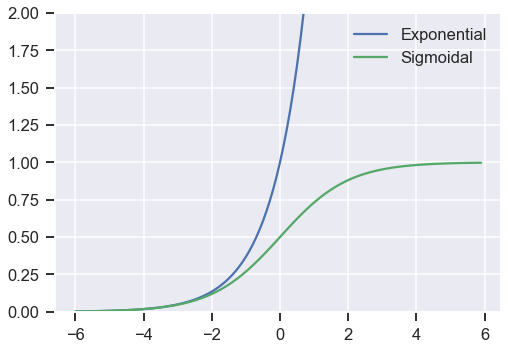

In [2]:
x = np.arange(-6,6, 0.1)
y_exp = np.exp(x)
y_sig = 1/(1+np.exp(-x))

plt.plot(x, y_exp, label='Exponential')
plt.plot(x, y_sig, label='Sigmoidal')
plt.ylim([0, 2])
plt.legend()
plt.show()

### Setting up PyMC3 Models

Models need to be set up inside a 'with' context so that the model knows which PyMC random variables are associated with which model. 

Anything declared inside the context comes under that model.

In [3]:
# Exponential Model 
def exp_model(x, y):
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()

    with pm.Model() as model:
        # Priors for unknown model parameters
        alpha = pm.Normal('alpha', mu=np.exp(y[0]), sigma=1)
        beta = pm.HalfNormal('beta', sigma=1)
        
        # Marginalize over the noise in the output as well 
        sigma = pm.HalfNormal('sigma', sigma=1)

        # Expected value of outcome
        # Note that for the exponential model, we can easily take the log and produce a linear model instead
        mu = pm.math.log(alpha)+(beta*x)

        # Likelihood (sampling distribution) of observations
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    return model

# Sigmoidal Model
def sig_model(x, y):
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()

    with pm.Model() as model:
        # Priors for unknown model parameters
        alpha = pm.HalfNormal('alpha', sigma=1)
        p0 = pm.Normal('p0', mu = y[0], sigma=1)
        beta = pm.HalfNormal('beta', sigma=1)
        
         # Marginalize over the noise in the output as well 
        sigma = pm.HalfNormal('sigma', sigma=1)

        # Expected value of outcome
        mu = alpha/(1+((alpha-p0)/p0)*pm.math.exp(-(beta*x)))

        # Likelihood (sampling distribution) of observations
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    return model

### Setting up PyMC3 Sampling

Sampling the model is extremely easily. PyMC is set up to do all the heavy lifting behind the scenes. One call to sample and that's it! 

We can also set up an easy method to gain access to our MCMC chains and make predictions on new data. 

In [4]:
def train_model(model, draws=5000, tune=5000, progressbar=True):
    with model:
        trace = pm.sample(
            draws=draws,  # number of times to keep iterating each chain
            tune=tune,    # number of times to tune each sample. Adjusts some PyMC hyperparameters during tuning
            random_seed=42,
            progressbar=progressbar  # , cores=4
        )
    return trace

def predict_model(model, trace, samples):
    with model:
        y_hat = pm.sample_posterior_predictive(trace, samples=samples)
    return y_hat['y_obs']

### Try This Out on Some Covid-19 Data...

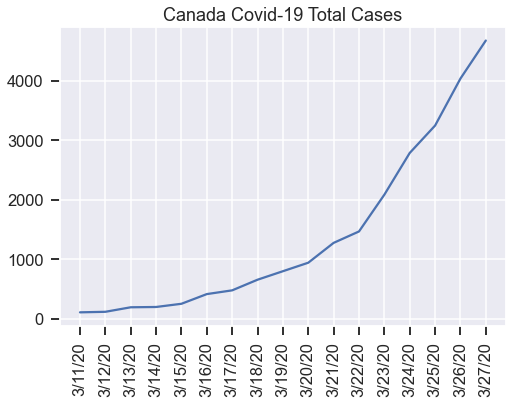

In [5]:
# get the dates, x array to use to reperesent dates numerically, and total case counts for a country 
country = 'Canada'
dates, x, y = get_country_v2(country, min_cases=100)

plt.plot(x, y)
plt.title('Canada Covid-19 Total Cases')
plt.xticks(x, dates, rotation=90)
plt.show()

In [6]:
# rescale data to be appropriate for models
# note that x_train is everything but the last 3 days, x_test is those last 3 days
x_train, y_train, x_scale, y_sig, y_exp, x_test, y_test, scale_sig, scale_exp, scalex = scale_data(x, y)

# produce the models
exp = exp_model(x_train, y_exp)
sig = sig_model(x_scale, y_sig)

# produce MCMC chains 
print()
print('Sampling for Exponential Model...')
print()
exp_trace = train_model(exp, draws=2000, tune=1000)

print()
print('Sampling for Sigmoidal Model...')
print()
sig_trace = train_model(sig, draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



Sampling for Exponential Model...



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [00:09<00:00, 1257.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



Sampling for Sigmoidal Model...



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, p0, alpha]
Sampling 4 chains, 48 divergences: 100%|█████████████████████████████████████| 12000/12000 [00:17<00:00, 693.89draws/s]
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


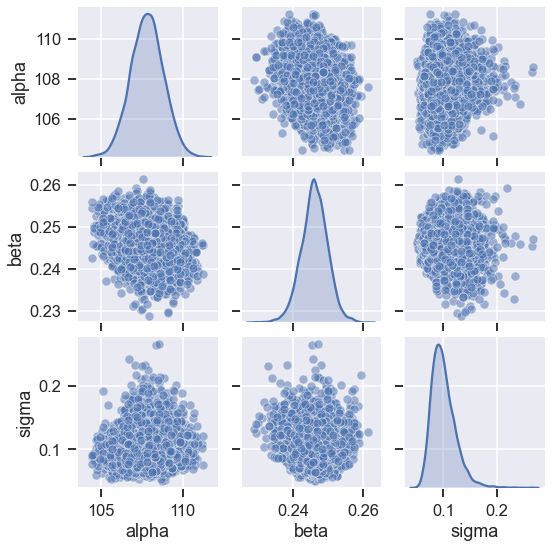

In [7]:
# Check Out The Parameter Posteriors
sns.pairplot(pm.trace_to_dataframe(exp_trace), plot_kws={'alpha':0.5}, diag_kind='kde')
plt.show()

In [8]:
# Make predictions on future data

# Set up the new x values up to 2 weeks in future
last = len(x)
num_days = 14
extend = np.arange(last, last + num_days)

x_updated = np.append(x, extend)
x_updated_scaled = scalex.transform(x_updated.reshape(-1, 1)).flatten()

# Need to pass in an 'observed_y', even though it isn't used
y_updated = np.empty(x_updated.shape)

# set up new model that contains the new data
exp_updated = exp_model(x_updated, y_updated)

# new model, new data
sig_updated = sig_model(x_updated_scaled, y_updated)

# make predictions 
# note that you usually don't take the entire sample space, but discard a 'burn-in' portion where it's still settling down 
# from possibly poor priors
y_exp_pred = predict_model(exp_updated, exp_trace[500:], samples=1000)
y_sig_pred = predict_model(sig_updated, sig_trace[500:], samples=1000)

C:\Users\linds\Anaconda3\envs\pymc3v2\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 738.37it/s]
C:\Users\linds\Anaconda3\envs\pymc3v2\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 640.67it/s]


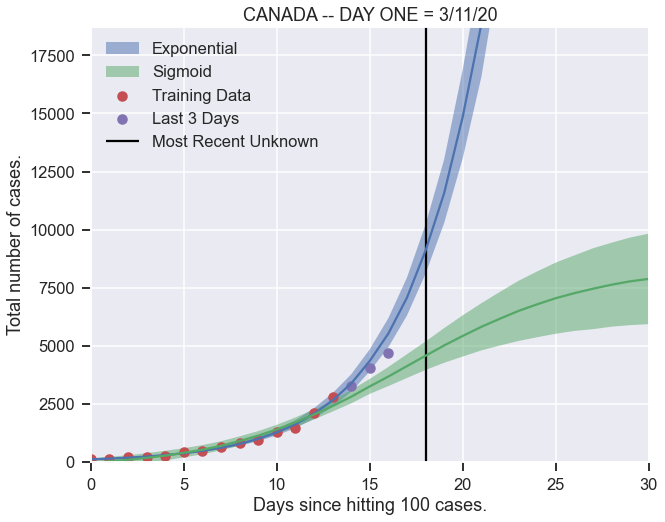

In [9]:
# Plot Results
y_exp_avg = np.mean(y_exp_pred, axis=0).reshape(-1, 1)
y_exp_std = 1 * np.std(y_exp_pred, axis=0).reshape(-1, 1)

y_sig_avg = np.mean(y_sig_pred, axis=0).reshape(-1, 1)
y_sig_std = 1 * np.std(y_sig_pred, axis=0).reshape(-1, 1)

y_exp_high = scale_exp.inverse_transform(y_exp_avg + y_exp_std).flatten()
y_exp_low = scale_exp.inverse_transform(y_exp_avg - y_exp_std).flatten()

y_sig_high = scale_sig.inverse_transform(y_sig_avg + y_sig_std).flatten()
y_sig_low = scale_sig.inverse_transform(y_sig_avg - y_sig_std).flatten()

y_exp_avg_1 = scale_exp.inverse_transform(y_exp_avg).flatten()
y_sig_avg_1 = scale_sig.inverse_transform(y_sig_avg).flatten()

plt.figure(figsize=(10, 8))
plt.plot(x_updated, y_exp_avg_1)
plt.plot(x_updated, y_sig_avg_1)
plt.fill_between(x_updated, y_exp_high, y_exp_low, alpha=0.5, label='Exponential')
plt.fill_between(x_updated, y_sig_high, y_sig_low, alpha=0.5, label='Sigmoid')
plt.scatter(x_train, y_train, label='Training Data')
plt.scatter(x_test, y_test, label='Last 3 Days')
plt.vlines(last + 1, -0.5, max(y) + 100 * max(y), label='Most Recent Unknown')

ymax = max(y) + 3 * max(y)
plt.ylim([-0.5, ymax])
plt.xlim([x_updated[0], x_updated[-1]])
plt.legend(loc='upper left')
plt.title(country.upper() + ' -- DAY ONE = {:s}'.format(dates[0].upper()))
plt.xlabel('Days since hitting 100 cases.')
plt.ylabel('Total number of cases.')
plt.show()

## 3. Voila and iPyWidgets

### Voila

* Now that we have a model, we want to share it with the world! There are many, many, many... different ways of getting python code out there, this will focus on one simple method.

* The first thing we use is Voila, which turns Jupyter Notebooks into standalone apps. 

* Voila will execute all of the code in a notebook, hide it, and display results.

* To run voila to preview an app/dashboard, simply run: ```voila \path\to\notebook.ipynb```. A call without the path will execute every notebook in the current directory path. 

<img style="float: left; margin:10px 2000px 10px 10px" src="slide_files/start_voila.png" width="600" height="300" />
 
* This will start a new localhost that runs each cell,

<img style="float: left; margin:10px 2000px 10px 10px"  src="slide_files/voila_loading.png" width="400" height="300" />

* And previews the notebook for you once it has completely loaded.

<img style="float: left; margin:10px 2000px 10px 10px" src="slide_files/voila_loaded.png" width="600" height="300" />


## 3. Voila and iPyWidgets

### iPyWidgets

* In order to make our notebook interactive, we enable some basic widgets. 

* These allow users to interact with functions: the widget contains a parameter that will be sent to the function.

* Calling the function from within either ```interact``` or ```interact_manual``` will then display the widgets and any updates to the output that go with the changes. 

In [10]:
def simple_plot(plot_type = 'cos', freq = 0.1):
    x = np.arange(0, 4*np.pi, 0.01)
    xlabels = np.arange(0, 4*np.pi+0.1, np.pi/2)
    
    if plot_type == 'cos':
        y = np.cos(freq*x)
    elif plot_type == 'sin':
        y = np.sin(freq*x)
    else:
        y = freq*x
        plot_type = ''
        
    plt.plot(x, y)
    plt.title(r'{:s}({:0.3f} x)'.format(plot_type, freq))
    plt.xticks(xlabels)
    plt.show()
    
drop_down_widget = widgets.Dropdown(
    options=['cos', 'sin', 'linear'],
    value='cos',
    description='Function: ',
    disabled=False,
)

slide_widget = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=1,
    step=0.05,
    description='omega: ',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=False,
    readout_format='.3f',
)

out = interact(simple_plot, plot_type = drop_down_widget, freq = slide_widget)     

interactive(children=(Dropdown(description='Function: ', options=('cos', 'sin', 'linear'), value='cos'), Float…

## 4. Heroku

* Voila gives us a basic app to play with, but it's stuck on your local machine. 

* To deploy online, we need to upload to a server. 

* Again, we have many options for doing this. Here we focus on Heroku. 

The basic steps to deploy with Heroku are as follows: 

1. Create a Heroku account (free) and install the CLI on your machine. Once the CLI is installed, make sure you are logged in by running:

    ```heroku login```

2. Create a git repo in the directory where you are working.

    ```git init```

3. In your repo, make sure you have the following:

    `requirements.txt`
    
    * This can be made using ```pip freeze > requirements.txt``` in your directory. 
    * This will have all the python requirements and packages needed for the project. 
    
   `runtime.txt`
   
    * This should contain a single line with the python version you are using: ```python-3.7.5```
    
   `Procfile`
    
    * This contains the call to voila to get the app running: web: ```voila app.ipynb --port=$PORT --no-browser --enable_nbextensions=True```
    
4. Push and commit everything in the repo. 

    ``` git add . ```
    
    ```git push -m "My nifty app."```
    
5. Create the heroku app

    ``` heroku create ```
    
    There are options to give it your own name, but by default it will just be given one at random.
    
6. Push the code to heroku

    ``` git push heroku master ```
    
    This will take a while to run as it sets up the python environment. 
    
7. Open the app and share with the world!

    ``` heroku open ```
    
    This will open the online page that can be shared. Logging into heroku will allow you to view statistics and information about the app. 
    
    
            